In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

total_runs = 110000

### One-introduction simulation data collation

In [2]:
def get_int(file_path):
    with open(file_path, 'r') as f:
        return int(f.readline().split()[0])

failure_count = 0
AB_count = 0
CC_count = 0

output_file_path = 'main_one_intro_output.tsv'

with open(output_file_path, 'w') as output_file:
    # Write a header row (include a newline at the end)
    output_file.write('run\tfailures\tAB\tCC\thash\n')
    
    for run in range(total_runs):
        # Construct paths for each run's files
        dir_path = os.path.join('main_analysis', 'one_intro', str(run))
        failures_path = os.path.join(dir_path, 'failures.txt')
        ab_path = os.path.join(dir_path, 'AB.txt')
        cc_path = os.path.join(dir_path, 'CC.txt')
        final_hash_path = os.path.join(dir_path, 'final_tree_hash.txt')
        
        # Read values from each file
        failures = get_int(failures_path)
        ab = get_int(ab_path)
        cc = get_int(cc_path)
        with open(final_hash_path, 'r') as fh:
            final_hash = fh.readline().strip()
        
        # Write to output file: run, failures, AB, CC, final_hash
        output_file.write(f'{run}\t{failures}\t{ab}\t{cc}\t{final_hash}\n')
        
        # Update counters
        failure_count += failures
        AB_count += ab
        CC_count += cc

print('One intro results:')
print(f'failure count: {failure_count}')
print(f'AB count:      {AB_count}')
print(f'CC count:      {CC_count}')    

One intro results:
failure count: 398305
AB count:      3422
CC count:      144


### Two-introduction simulation data collation

In [3]:
# We'll accumulate AB and CC across runs in 2D arrays
AB_sum_array = None
CC_sum_array = None

output_file_path = 'main_two_intro_output.tsv'

with open(output_file_path, 'w') as output_file:
    output_file.write('run\tAB_nonzero\tCC_nonzero\thash\n')
    
    for run in range(total_runs):
        dir_path = os.path.join('main_analysis', 'two_intro', str(run))
        ab_path = os.path.join(dir_path, 'AB_array.csv')
        cc_path = os.path.join(dir_path, 'CC_array.csv')
        final_hash_path = os.path.join(dir_path, 'final_tree_hash.txt')

        AB = np.loadtxt(ab_path, delimiter=",")  
        CC = np.loadtxt(cc_path, delimiter=",")
        with open(final_hash_path, 'r') as f:
            final_hash = f.readline().strip()
        
        # Get the indices of non-zero entries (just for logging)
        AB_nonzero = np.nonzero(AB)
        CC_nonzero = np.nonzero(CC)
        AB_nonzero_pairs_str = ",".join(f"({r},{c})" for r,c in zip(*AB_nonzero))
        CC_nonzero_pairs_str = ",".join(f"({r},{c})" for r,c in zip(*CC_nonzero))
        output_file.write(f'{run}\t{AB_nonzero_pairs_str}\t{CC_nonzero_pairs_str}\t{final_hash}\n')
        
        # Initialize our accumulators on the first valid run
        if AB_sum_array is None:
            AB_sum_array = np.zeros_like(AB)
            CC_sum_array = np.zeros_like(CC)
        
        # Accumulate (element-wise sum) across all runs
        AB_sum_array += AB
        CC_sum_array += CC

# Now print the final 2D sums
print('Two intro results:')
print("AB frequencies:\n", AB_sum_array/total_runs)
print("CC frequencies:\n", CC_sum_array/total_runs)
print("Max. AB frequency:", np.max(AB_sum_array/total_runs))
print("Max. CC frequency:", np.max(CC_sum_array/total_runs))


Two intro results:
AB frequencies:
 [[0.00372727 0.0045     0.00501818 0.00449091 0.00372727 0.0031
  0.00198182]
 [0.00476364 0.0052     0.00533636 0.00479091 0.00397273 0.0031
  0.00222727]
 [0.00511818 0.00504545 0.00508182 0.00530909 0.00450909 0.00367273
  0.00247273]
 [0.00480909 0.0047     0.00532727 0.00509091 0.00450909 0.00366364
  0.00280909]
 [0.00356364 0.00463636 0.00438182 0.00439091 0.00388182 0.00355455
  0.00272727]
 [0.00292727 0.00366364 0.00345455 0.00361818 0.00358182 0.00308182
  0.00293636]
 [0.00194545 0.00257273 0.00247273 0.00286364 0.00292727 0.00261818
  0.00232727]]
CC frequencies:
 [[0.00382727 0.005      0.00646364 0.00625455 0.00579091 0.0049
  0.00366364]
 [0.00553636 0.00796364 0.00969091 0.01022727 0.00938182 0.00788182
  0.00608182]
 [0.00669091 0.00971818 0.01251818 0.01359091 0.01227273 0.01142727
  0.00961818]
 [0.00651818 0.01028182 0.01389091 0.01589091 0.0164     0.01524545
  0.01276364]
 [0.00633636 0.00911818 0.01347273 0.01634545 0.01800909

### Two-introduction likelihood plots

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


def surface_plot_two(data1, title1, data2, title2, legend, filename,
                     interp_method='bilinear', sensitivity_range=None):
    """
    Plots two heatmaps side by side with a shared colorbar.
    
    Parameters:
      - data1, data2: 2D numpy arrays with data defined at the coordinates 
                      {0,5,10,15,20,25,30}.
      - title1, title2: Titles for each subplot.
      - legend: Label for the colorbar.
      - filename: Base name for saving the output files.
      - interp_method: Interpolation method for imshow (default 'bilinear').
      - sensitivity_range: Optional tuple (vmin, vmax) to set a custom color range.
    """
    # Determine vmin and vmax. If sensitivity_range is provided, use it.
    if sensitivity_range is None:
        vmin = min(data1.min(), data2.min())
        vmax = max(data1.max(), data2.max())
    else:
        vmin, vmax = sensitivity_range

    # Data is defined at the points: 0,5,10,15,20,25,30 (7 points in each direction).
    # Each cell has width and height 5.
    dx = 5
    dy = 5
    # Setting extent so that pixel centers match the data coordinates.
    # With extent = (left, right, bottom, top), imshow places the centers at:
    # left+dx/2, left+3*dx/2, ..., right-dx/2.
    # To have the first pixel centered at 0 and the last at 30, we use:
    extent = (-dx/2, 30 + dx/2, -dy/2, 30 + dy/2)  # (-2.5, 32.5, -2.5, 32.5)

    # Create a figure with two subplots side by side.
    fig, axs = plt.subplots(1, 2, figsize=(5, 3))
    fig.subplots_adjust(top=0.9, bottom=0.1)
    

    im1 = axs[0].imshow(data1, cmap="inferno", origin='lower', extent=extent,
                        vmin=vmin, vmax=vmax, interpolation=interp_method)
    im2 = axs[1].imshow(data2, cmap="inferno", origin='lower', extent=extent,
                        vmin=vmin, vmax=vmax, interpolation=interp_method)
    

    ticks = [0, 10, 20, 30]
    for ax, title in zip(axs, [title1, title2]):
        ax.set_title(title)
        ax.set_xlabel("$t_x$ (days)")
        ax.set_ylabel("$t_y$ (days)")
        ax.set_aspect('equal', adjustable='box')
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xlim(0, 30)
        ax.set_ylim(0, 30)
    
    fig.subplots_adjust(wspace=0.4)
    
    # Create a single shared colorbar.
    cbar = fig.colorbar(im1, ax=axs, label=legend, orientation='vertical',shrink=0.55, pad=0.04)
    
   
    # Save the figure.
    fig.savefig(f"{filename}.png", dpi=600)
    fig.savefig(f"{filename}.ps", format='ps', dpi=600)
    
    plt.show()



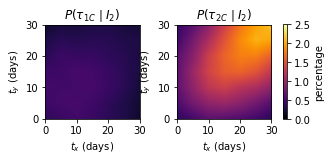

In [105]:
surface_plot_two(AB_sum_array/total_runs * 100, "$P(\\tau_{1C} \\mid I_2)$", \
                 CC_sum_array/total_runs * 100, "$P(\\tau_{2C} \\mid I_2)$",\
                 "percentage", "two-intro",\
                sensitivity_range=(0,2.5))

### Bayes factor plot

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


def surface_plot(data, legend, filename,
                     interp_method='bilinear', sensitivity_range=None):
    """
    Plots one heatmaps side by side with a shared colorbar.
    
    Parameters:
      - data1, data2: 2D numpy arrays with data defined at the coordinates 
                      {0,5,10,15,20,25,30}.
      - title1, title2: Titles for each subplot.
      - legend: Label for the colorbar.
      - filename: Base name for saving the output files.
      - interp_method: Interpolation method for imshow (default 'bilinear').
      - sensitivity_range: Optional tuple (vmin, vmax) to set a custom color range.
    """
    # Determine vmin and vmax. If sensitivity_range is provided, use it.
    if sensitivity_range is None:
        vmin = min(data.min(), data.min())
        vmax = min(data.max(), data.max())
    else:
        vmin, vmax = sensitivity_range

    # Data is defined at the points: 0,5,10,15,20,25,30 (7 points in each direction).
    # Each cell has width and height 5.
    dx = 5
    dy = 5
    # Setting extent so that pixel centers match the data coordinates.
    # With extent = (left, right, bottom, top), imshow places the centers at:
    # left+dx/2, left+3*dx/2, ..., right-dx/2.
    # To have the first pixel centered at 0 and the last at 30, we use:
    extent = (-dx/2, 30 + dx/2, -dy/2, 30 + dy/2)  # (-2.5, 32.5, -2.5, 32.5)

    # Create a figure with two subplots side by side.
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    fig.subplots_adjust(top=0.9, bottom=0.2)
    

    im = ax.imshow(data, cmap="inferno", origin='lower', extent=extent,
                        vmin=vmin, vmax=vmax, interpolation=interp_method)   

    ticks = [0, 10, 20, 30]

    ax.set_xlabel("$t_x$ (days)")
    ax.set_ylabel("$t_y$ (days)")
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    
   
    # Create a single shared colorbar.
    cbar = fig.colorbar(im, ax=ax, label=legend, orientation='vertical',shrink=1, pad=0.04)
    
   
    # Save the figure.
    fig.savefig(f"{filename}.png", dpi=600)
    fig.savefig(f"{filename}.ps", format='ps', dpi=600)
    
    plt.show()


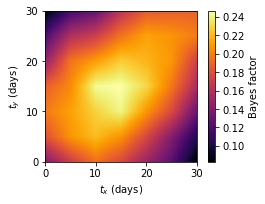

Max. Bayes factor is 0.24679774030208 at (15, 15) days


In [154]:
recCA_results = np.array([77.28, 8.18, 10.49, 3.71])/100 # linB, linA, C/C, T/T
Z = (AB_sum_array/total_runs * sum(recCA_results[:2]) + CC_sum_array/total_runs * sum(recCA_results[2:]))/\
    (3422/total_runs * sum(recCA_results[:2]) + 144/total_runs * sum(recCA_results[2:]))
surface_plot(Z, "Bayes factor", "BF")

print(f"Max. Bayes factor is {np.max(Z)} " \
+ f"at ({np.unravel_index(np.argmax(Z), Z.shape)[0]*5}, {np.unravel_index(np.argmax(Z), Z.shape)[1]*5}) days")


### Check for higher Bayes factors as $t_x$ and $t_y$ approach infinity

In [215]:
import treeswift

def get_lineages(parent: treeswift.Node):
    """
    Recursively traverse a subtree from 'parent' to count the number of descendent lineages.

    :param parent: A node in a TreeSwift tree.
    :return: The number of descendent lineages.
    """
    lineages = 0

    for child in parent.child_nodes():
        if child.is_leaf():
            lineages += 1
        else:
            mutations = np.random.poisson(29903 * 0.00092 * child.get_edge_length())
            if mutations > 0:
                lineages += 1
            else:
                lineages += get_lineages(child)

    return lineages

CC_max_count = 0
for run in range(total_runs):
    dir_path = os.path.join('main_analysis', 'two_intro', str(run))
    # check relative size
    size_0 = 0
    size_1 = 0
    with open(os.path.join(dir_path, "sample_times.txt")) as f:
        for line in f:
            fields = line.split('\t')
            if fields[0].endswith('_0'):
                size_0 += 1
            elif fields[0].endswith('_1'):
                size_1 += 1
    if not (0.3 <= size_0/(size_0+size_1) <= 0.7):
        continue
    # check polytomies
    tree = treeswift.read_tree_newick(os.path.join(dir_path, "final_tree.nwk"))
    leaf_labels = {leaf.get_label() for leaf in tree.traverse_leaves()}
    mrca_node = tree.mrca(leaf_labels)
    lineages_0 = get_lineages(mrca_node.child_nodes()[0])
    if lineages_0 < 100:
        continue
    lineages_1 = get_lineages(mrca_node.child_nodes()[1])
    if lineages_1 < 100:
        continue
    CC_max_count += 1

print("Max. CC frequency:", CC_max_count/total_runs)

Max. CC frequency: 0.024627272727272727


In [217]:
Zmax = (AB_sum_array[6][6]/total_runs * sum(recCA_results[:2]) + CC_max_count/total_runs * sum(recCA_results[2:]))/\
    (3422/total_runs * sum(recCA_results[:2]) + 144/total_runs * sum(recCA_results[2:]))

print(f"Upper boud for second max. Bayes factor is {Zmax} ")

Upper boud for second max. Bayes factor is 0.20491623250205818 
